## import packages

In [1]:
import sys
import time
from pathlib import Path
import os

import pandas as pd
import numpy as np

from sklearn.preprocessing import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

## set up for imports of .py modules by adding path to sys.path

In [2]:
path = Path.cwd()
mods_dir = "/modules"
path_to_project_directory = path.parent
sys.path.insert(1, str(path_to_project_directory))
sys.path.insert(1, str(path_to_project_directory) + mods_dir)
print(f"The working directory has been set to: {str(path_to_project_directory)}")

The working directory has been set to: /Users/nelsonfarrell/Documents/Northeastern/5220/final_project


## import python modules

In [3]:
import modules.regression_utils as reg_utils
import modules.sml_utils as sml_utils
import modules.bin_class_utils as class_utils
import modules.assign_and_lab_utils as al_utils
import modules.assign_3_utils as assign_3_utils
import modules.multi_colinearity_utils as mc_utils

## helpful functions

## parameters

In [8]:
# with_milti_colinearity = True
# if with_milti_colinearity:
#     data_set = 'data_set_1'
#     path_to_data = 'data/synth_2_class_10000_0_55_0_45_15_6_4_1_4_0_0_0_5_w_noms.csv'
#     path_to_col_idx_shuffle_map = 'data/synth_2_class_10000_0_55_0_45_15_6_4_1_4_0_0_0_5_w_noms_col_idx_shuffle_map.pkl'
# else:
#     data_set = 'data_set_2'
#     path_to_data = 'data/synth_2_class_10000_0_55_0_45_15_6_0_0_9_0_0_0_5_w_noms.csv'
#     path_to_col_idx_shuffle_map = 'data/synth_2_class_10000_0_55_0_45_15_6_0_0_9_0_0_0_5_w_noms_col_idx_shuffle_map.pkl'

path_to_data = "../data/filtered_datasets/data_set_D_C.csv"

# step 1 parameters - check for missingness in target vector
target_attr = 'Segmentation'

# step 2 parameters - train/test split
test_size = 0.20
train_test_split_random_state = 42

# step 3 parameters - train/validation split

# step 5 parameters - identify attributes with missingness above threshold
missingness_threshold = 0.20

# step 9 parameters - build a composite estimator
target_encoder_random_state = 42

# model selection parameters
# if with_milti_colinearity:
#     num_std = 1.0  # number of mse standard deviations to give up for a reduction in variables
# else:
#     num_std = 1.0  # number of mse standard deviations to give up for a reduction in variables
num_std = 1.0

model_type = 'LogisticRegressionCV'  # model specific cv from sklearn
cv_folds = 5  # number of folds for model specific cv
scoring='neg_log_loss'
max_iter=100
class_weight=None  # changing this could impact regularization

penalty='l1'  # Cs describes the inverse of regularization strength

if penalty == 'l1':
    
    l1_ratio_list = None
    solver = 'saga'  # solver can be {‘liblinear’, ‘saga’}
    cap_c_s = np.logspace(-4, 1, 50)  # l1 - Cs describes the inverse of regularization strength
    
elif penalty == 'l2':

    l1_ratio_list = None
    solver = 'saga'  # solver can be {‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}
    cap_c_s = np.logspace(-7, 1, 50)  # l2 - Cs describes the inverse of regularization strength
    
elif penalty == 'elasticnet':
    
    l1_ratio_list = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0]  # values of l1 for ElasticNetCV to search over
    solver = 'saga'  # solver can be {‘saga’}
    
else:
    
    sys.exit(f'penalty {penalty} is unrecognized')

# understand nature of synthetic attributes
col_idx_shuffle_map = False

# check out attribute multi colinearity
check_out_multi_colinearity = False

## set up to time script run time

In [9]:
start = time.time()

## read in the data and get the size of the data

In [10]:
df = pd.read_csv(path_to_data)
print(df.shape)
df.head()

(4238, 12)


,Unnamed: 0,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,5,461319,Male,Yes,56,No,Artist,0.0,Average,2.0,Cat_6,C
2,6,460156,Male,No,32,Yes,Healthcare,1.0,Low,3.0,Cat_6,C
3,7,464347,Female,No,33,Yes,Healthcare,1.0,Low,3.0,Cat_6,D
4,8,465015,Female,Yes,61,Yes,Engineer,0.0,Low,3.0,Cat_7,D


## out of pipeline preprocessing

### These operations cannot be completed in the scikit-learn pipeline.

### They should be identified and passed on the the data engineer as tasks conducted during extract/transform/load (ETL) if the model goes to production.

## 1. check for missingness in target vector

In [11]:
print(df.shape)
df = df.dropna(subset=target_attr)
print(df.shape)

(4238, 12)
(4238, 12)


## 2. label binarize

In [12]:
if pd.api.types.infer_dtype(df[target_attr]) == 'string':
    df, le_name_mapping = class_utils.label_binarize_binary(df, target_attr, print_results=True)
else:
    print(f'df[target_attr] is not a string attribute')


df[target_attr] is a string attribute

df.loc[0:5, target_attr]:
0    D
1    C
2    C
3    D
4    D
Name: Segmentation, dtype: object

Segmentation
D    0.535158
C    0.464842
Name: proportion, dtype: float64

label encode df[target_attr]

after label encoding df[target_attr]

Segmentation
0.0    0.535158
1.0    0.464842
Name: proportion, dtype: float64

df.loc[0:5, target_attr]:
0    0.0
1    1.0
2    1.0
3    0.0
4    0.0
Name: Segmentation, dtype: float64

lb_name_mapping: {0: 'D', 1: 'C'}


## 3. train/test split

In [13]:
train_cap_x_df, train_y_df = sml_utils.perform_the_train_test_split(df, test_size, train_test_split_random_state, val=False)

*************************

df.shape:
(4238, 12)

*************************

train_df.csv:
(3390, 11) (3390, 1)

*************************

test_df.csv
(848, 11) (848, 1)


## 4. train/validation split

### We will use the k-fold cross validation to select a model - no validation set is required.

## check out the attribute types

In [14]:
train_cap_x_df.dtypes

Unnamed: 0           int64
ID                   int64
Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
Var_1               object
dtype: object

## 5. identify attributes with  missingness above threshold

In [15]:
return_dict = sml_utils.get_missingness(train_cap_x_df, missingness_threshold)
missingness_drop_list = return_dict['missingness_drop_list']

Unnamed: 0 missingness = 0.0
ID missingness = 0.0
Gender missingness = 0.0
Ever_Married missingness = 0.019174041297935103
Age missingness = 0.0
Graduated missingness = 0.008259587020648967
Profession missingness = 0.016519174041297935
Work_Experience missingness = 0.10206489675516224
Spending_Score missingness = 0.0
Family_Size missingness = 0.04365781710914454
Var_1 missingness = 0.010914454277286136

missingness_drop_list:
[]


## 6. identify non machine learning attributes

In [16]:
sml_utils.check_for_complete_unique_attrs(train_cap_x_df)

the data frame has 3390 rows

Unnamed: 0 has 3390 unique values and is dtype int64 examine more closely
ID has 3390 unique values and is dtype int64 examine more closely
Gender has 2 unique values and is dtype object 
Ever_Married has 2 unique values and is dtype object 
Age has 67 unique values and is dtype int64 
Graduated has 2 unique values and is dtype object 
Profession has 9 unique values and is dtype object 
Work_Experience has 15 unique values and is dtype float64 
Spending_Score has 3 unique values and is dtype object 
Family_Size has 9 unique values and is dtype float64 
Var_1 has 7 unique values and is dtype object 


['Unnamed: 0', 'ID']

In [17]:
non_ml_attr_list = ['Unnamed: 0', "ID"]

## 7. identify attributes to exclude from machine learning

In [18]:
train_cap_x_df.columns

Index(['Unnamed: 0', 'ID', 'Gender', 'Ever_Married', 'Age', 'Graduated',
       'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size',
       'Var_1'],
      dtype='object')

In [19]:
ml_attr_drop_list = ["Work_Experience", "Ever_Married", "Age", "Family_Size"]

## 8. establish machine learning attribute configuration

In [21]:
ml_ignore_list = missingness_drop_list + non_ml_attr_list + ml_attr_drop_list
ml_ignore_list

['Unnamed: 0', 'ID']

In [22]:
train_cap_x_df.columns

Index(['Unnamed: 0', 'ID', 'Gender', 'Ever_Married', 'Age', 'Graduated',
       'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size',
       'Var_1'],
      dtype='object')

In [23]:
train_cap_x_df.dtypes

Unnamed: 0           int64
ID                   int64
Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
Var_1               object
dtype: object

In [28]:
# identify the remaining numerical attributes to be used in machine learning and enter them into the 
# numerical_attr list below.

numerical_attr = ["Age", "Work_Experience", "Family_Size"]

# identify the remaining nominal attributes to be used in machine learning and enter them into the 
# nominal_attr list below.

nominal_attr = ["Gender", "Ever_Married", "Graduated", "Profession", "Spending_Score", "Var_1"]

assert(train_cap_x_df.shape[1] == len(ml_ignore_list) + len(nominal_attr) + len(numerical_attr))  # got them all?

print(f'ml_ignore_list: {ml_ignore_list}')
print(f'\nnumerical_attr: {numerical_attr}')
print(f'nominal_attr: {nominal_attr}')

print(f'\nnumber of machine learning attributes: {len(numerical_attr) + len(nominal_attr)}')
print(f'\nnumerical_attr and nominal_attr: {numerical_attr + nominal_attr}')

ml_ignore_list: ['Unnamed: 0', 'ID']

numerical_attr: ['Age', 'Work_Experience', 'Family_Size']
nominal_attr: ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']

number of machine learning attributes: 9

numerical_attr and nominal_attr: ['Age', 'Work_Experience', 'Family_Size', 'Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']


## 9. assess target attribute imbalance

In [29]:
train_y_df[target_attr].unique().tolist()

[1.0, 0.0]

In [30]:
train_y_df[target_attr].value_counts(normalize=True)

Segmentation
0.0    0.533333
1.0    0.466667
Name: proportion, dtype: float64

## here we deviate from the binary classification flow - we are working to find a less complex model by variable selection

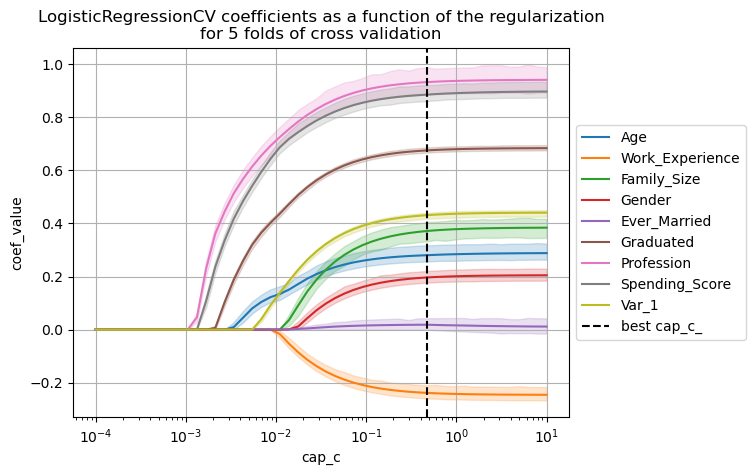


coef_:
[ 0.28330603 -0.23915351  0.37295661  0.19696149  0.00974165  0.67609026
  0.93269105  0.89066269  0.43308984]

scikit-learn model specific cv LogisticRegressionCV was fitted with penalty l1 with the following results

best regularization parameters:
   best C: 0.47148663634573945
   best l1_ratio: None

the model coefficients at the best regularization hyperparameters are:
   attribute Age coefficient: 0.2833060262518736
   attribute Work_Experience coefficient: -0.23915351345816344
   attribute Family_Size coefficient: 0.37295661422601184
   attribute Gender coefficient: 0.19696149237149274
   attribute Ever_Married coefficient: 0.009741651472209439
   attribute Graduated coefficient: 0.6760902628044507
   attribute Profession coefficient: 0.9326910456969146
   attribute Spending_Score coefficient: 0.890662686781206
   attribute Var_1 coefficient: 0.4330898361139713

number of attributes with zero coefficient: 0

the model cv average_precision_score is 0.9107283931285778

the

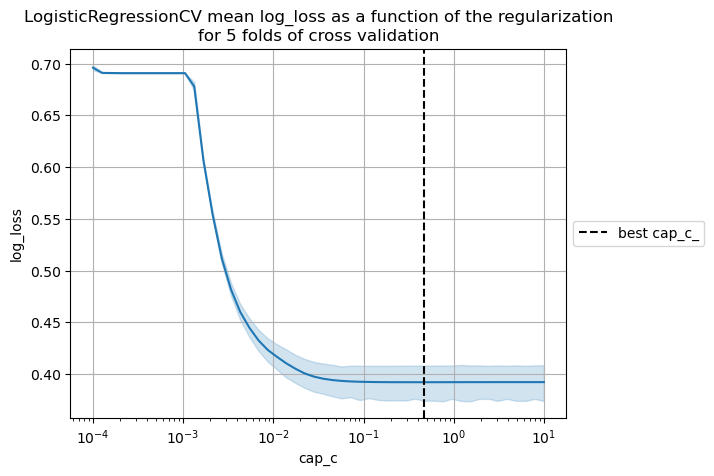




next we consider trading off log_loss to get simpler model - the plot above shows the trade space

the minimum mean log_loss from LogisticRegressionCV is located at cap_c 0.47148663634573945

at that cap_c the minimum mean log_loss from cv is 0.3921269273335718

at that cap_c the standard deviation of the log_loss from cv is 0.021515906808434845

consider trading 1.0 standard deviations of log_loss to move towards more regulation
and more zero coefficients

this means moving to a new cap_c 0.010985411419875584 where the log_loss is 0.41364283414200664
   - the log_loss has increased by 0.05486975086036835%

the model cv average_precision_score is 0.9058755749679573
   - this is a change of -0.004852818160620442

the model cv roc_auc_score is 0.8935652071131368
   - this is a change of -0.006742398827066953

the plots below show the original cap_c from LogisticRegressionCV and the new cap_c
for both the coefficient paths and the mean log_loss path






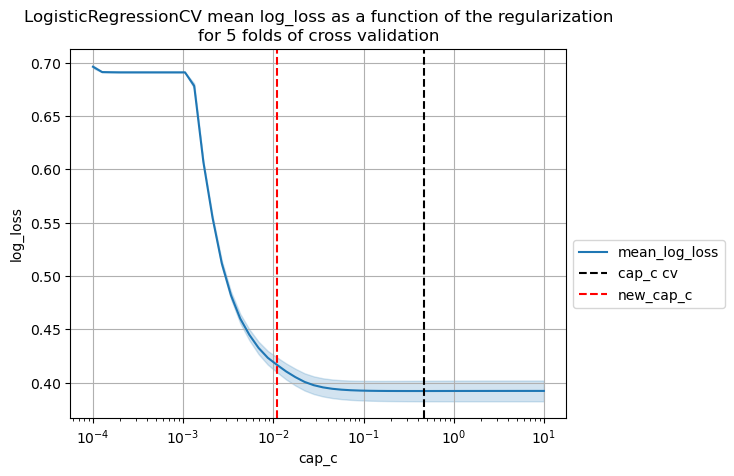

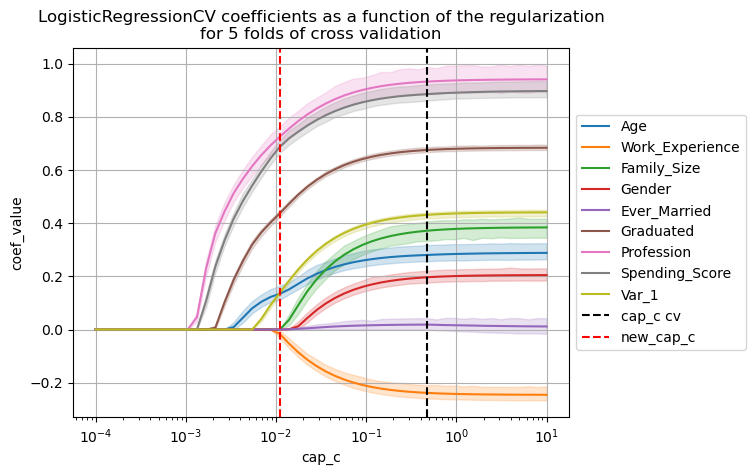





by shifting from the best cap_c = 0.47148663634573945 given by LogisticRegressionCV to a new cap_c = 0.010985411419875584
we have increased the number of zero coefficients from 0 to 4 giving us a simpler model

the cost of the simpler model is a 0.05486975086036835% increase in log_loss

the model cv average_precision_score is 0.9058755749679573
   - this is a change of -0.004852818160620442

the model cv roc_auc_score is 0.8935652071131368
   - this is a change of -0.006742398827066953


the original model coefficients were:

   attribute Age coefficient: 0.2833060262518736
   attribute Work_Experience coefficient: -0.23915351345816344
   attribute Family_Size coefficient: 0.37295661422601184
   attribute Gender coefficient: 0.19696149237149274
   attribute Ever_Married coefficient: 0.009741651472209439
   attribute Graduated coefficient: 0.6760902628044507
   attribute Profession coefficient: 0.9326910456969146
   attribute Spending_Score coefficient: 0.890662686781206
   attribu

In [31]:
return_dict = class_utils.model_specific_cv(
    
    cap_x_df=train_cap_x_df,
    y_df=train_y_df,
    nominal_attr=nominal_attr, 
    numerical_attr=numerical_attr, 
    
    model_type=model_type,
    
    te_random_state=target_encoder_random_state, 
    
    cap_c_s=cap_c_s, 
    cv_folds=cv_folds, 
    penalty=penalty, 
    scoring=scoring, 
    solver=solver, 
    max_iter=max_iter, 
    class_weight=class_weight, 
    l1_ratio_list=l1_ratio_list,
    
    num_std=num_std
)

preproc_cap_x_df = return_dict['preproc_cap_x_df']
model_type = return_dict['model_type']
fitted_model_cv = return_dict['fitted_model_cv']
fitted_coef_dict = return_dict['fitted_coef_dict']
new_fitted_coef_dict = return_dict['new_fitted_coef_dict']

### Inspect Multicollinearity 

In [41]:
a_num_attr_list = nominal_attr + numerical_attr
vifs_df = mc_utils.print_vifs(preproc_cap_x_df, a_num_attr_list, vif_inspection_threshold=2, ols_large_vifs=True)


****************************************
investigate multi co-linearity - calculate variance inflation factors:

Added a bias term to the data frame to construct the design matrix for assessment of vifs.
scale the attributes - but not the bias term

         attribute   vif
0            const  1.00
1           Gender  1.02
8  Work_Experience  1.04
6            Var_1  1.09
9      Family_Size  1.20
3        Graduated  1.37
4       Profession  1.68
7              Age  2.02
5   Spending_Score  2.26
2     Ever_Married  2.96

the attributes ['Age', 'Spending_Score', 'Ever_Married'] have vif values greater than 2 - let's look at the details of regressing them on the rest of the design matrix




Spending_Score
                            OLS Regression Results                            
Dep. Variable:         Spending_Score   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statist

         attribute   vif
0            const  1.00
1           Gender  1.02
8  Work_Experience  1.04
6            Var_1  1.09
9      Family_Size  1.20
3        Graduated  1.37
4       Profession  1.68
7              Age  2.02
5   Spending_Score  2.26
2     Ever_Married  2.96


[-0.32 -0.24 -0.2  -0.2  -0.18 -0.14 -0.08 -0.08 -0.07 -0.06 -0.06 -0.05
 -0.03 -0.03 -0.02 -0.    0.01  0.01  0.02  0.03  0.05  0.08  0.11  0.15
  0.19  0.24  0.32  0.36  0.39  0.43  0.45  0.49  0.51  0.54  0.64  0.73]

0.73

-0.32



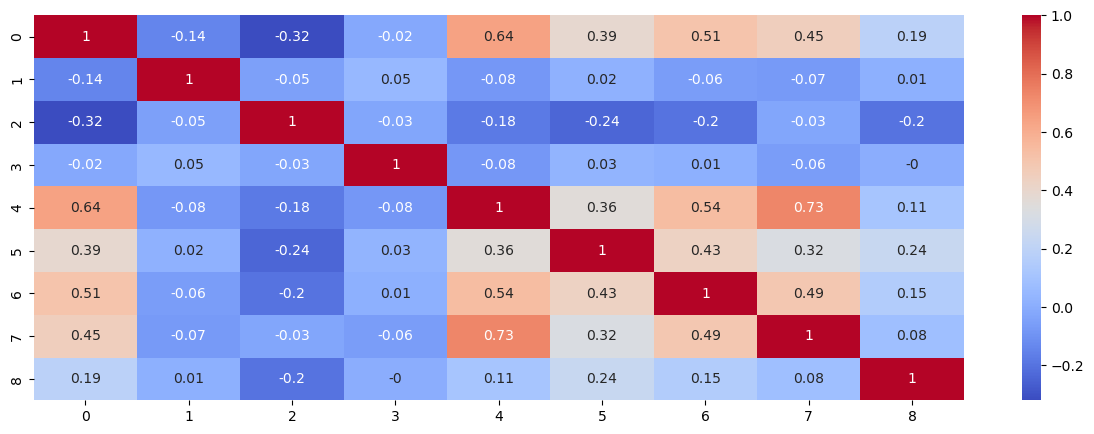

In [42]:
print(vifs_df)

correlation_matrix = preproc_cap_x_df.corr().round(2).values

triu_correlation_matrix = correlation_matrix[np.triu_indices(correlation_matrix.shape[0], k = 1)]

print()
flattened_corr_matrix = np.sort(triu_correlation_matrix.flatten())
print()
print(flattened_corr_matrix)
print()
print(flattened_corr_matrix.max())
print()
print(flattened_corr_matrix.min())

print()
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=ax)
plt.show()

### Temporarily Remove High Vif Attributes & Inspect

In [43]:
temp_numerical_attr = numerical_attr.copy()

# Put the attributes to remove her
temp_numerical_attr.remove('Ever_Married') 
# temp_numerical_attr.remove('attr_14') 

return_dict = class_utils.model_specific_cv(
    
    cap_x_df=train_cap_x_df,
    y_df=train_y_df,
    nominal_attr=nominal_attr, 
    numerical_attr=temp_numerical_attr, 
    
    model_type=model_type,
    
    te_random_state=target_encoder_random_state, 
    
    cap_c_s=cap_c_s, 
    cv_folds=cv_folds, 
    penalty=penalty, 
    scoring=scoring, 
    solver=solver, 
    max_iter=max_iter, 
    class_weight=class_weight, 
    l1_ratio_list=l1_ratio_list,
    
    num_std=num_std
)

ValueError: list.remove(x): x not in list

## check out script run time

In [ ]:
end = time.time()
print(f'script run time: {(end - start)/60} minutes')